# MONAI (Medical Open Network for AI)

MONAI: https://github.com/Project-MONAI

Tutorials referenced: https://github.com/Project-MONAI/tutorials

**Task** Get performance of specialized medical imaging classifer on GANSformer generated CTs versus real CTs.

**Expectations**
- We expect GANSformer images to "fool" MONAI.
- Good performance will show as poor performance from the MONAI classifier.
- Therefore, we expect MONAI to have a no-better-than-chance AUC classifying against GANSformer.

**Results**
- Indeed, MONAI performs no better than chance as measured by AUC and precision.
- We can conclude that GANSformer images are close enough to the real thing to fool a medical imaging classifier like MONAI.

In [380]:
import os
import numpy as np
import pandas as pd
import csv
import PIL
import cv2
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torchvision.io import read_image
from monai.utils import first, set_determinism
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.8.0
Numpy version: 1.21.1
Pytorch version: 1.8.0.post3
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.3.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0a0
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Prepare dataset

12487 images

11487 are real images from QURE.ai dataset (http://headctstudy.qure.ai/dataset)

1000 are GANsformer generated


- pre-process fake and real images to be the same dimensions (1,256,256)
- combine into one directory
- split into train, test, split
- create dataset and loaders with batch size 64 using pytorch

In [482]:
img_dir = "data/cts"
paths = os.listdir(img_dir)

In [483]:
print(len(paths)) 
print(len([path for path in paths if "Sample" not in path]))
print(len([path for path in paths if "Sample" in path])) 

12487
11487
1000


In [484]:
# real images are (512, 512)
img_path = paths[0]
image = PIL.Image.open(img_dir + "/" + img_path)
image = np.array(image)
image.shape 

(512, 512)

In [485]:
# GANSformer generated images are (256, 256, 3)
img_path = paths[12486]
image = PIL.Image.open(img_dir + "/" + img_path)
image = np.array(image)
image.shape

(256, 256, 3)

In [456]:
# pre-process all to be (1, 256, 256) to match pytorch model input dimensions
transform = transforms.Compose([transforms.Scale((256,256))])
for n, path in enumerate(paths):
    image = PIL.Image.open(img_dir + "/" + path) 
    image = image.convert("L") # remove color channels / convert to greyscale
    image = transform(image) # convert to (256,256)
    if "." not in path:
        if "Sample" in path:
            name = 'data/transformed_cts/generated_image'
        else:
            name = 'data/transformed_cts/image'
    image.save(name + str(n+1) + '.png')

In [490]:
updated_img_dir = 'data/transformed_cts'
updated_paths = os.listdir(updated_img_dir)
updated_paths = [path for path in updated_paths if '.png' in path]
img_files = [updated_img_dir+"/"+image for image in updated_paths]

In [491]:
img_files[:10]

['data/transformed_cts/generated_image4221.png',
 'data/transformed_cts/generated_image2888.png',
 'data/transformed_cts/image10104.png',
 'data/transformed_cts/image9652.png',
 'data/transformed_cts/generated_image2650.png',
 'data/transformed_cts/generated_image9705.png',
 'data/transformed_cts/image3419.png',
 'data/transformed_cts/generated_image6436.png',
 'data/transformed_cts/generated_image1359.png',
 'data/transformed_cts/image4376.png']

In [492]:
# define train, validation, test split
val_frac = 0.1
test_frac = 0.1
length = len(paths)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

img_labels = [0 if "generated" in path else 1 for path in updated_paths]

train_x = [img_files[i] for i in train_indices]
train_y = [img_labels[i] for i in train_indices]
val_x = [img_files[i] for i in val_indices]
val_y = [img_labels[i] for i in val_indices]
test_x = [img_files[i] for i in test_indices]
test_y = [img_labels[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 9991, Validation count: 1248, Test count: 1248


In [493]:
# create dataset
class CT_Dataset(Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [494]:
# define transforms for training and validation sets
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

In [495]:
# define datasets for training, validation, and testing
training = CT_Dataset(train_x, train_y, transforms=train_transforms)
validating = CT_Dataset(val_x, val_y, transforms=val_transforms)
testing = CT_Dataset(test_x, test_y, transforms=val_transforms)

In [496]:
# check images correctly loaded
training.__getitem__(50)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [497]:
# check images have correct shape (should be [1, 256, 256] so that with batch it becomes [64, 1, 256, 256])
training.__getitem__(50)[0].shape

torch.Size([1, 256, 256])

In [504]:
train_loader = DataLoader(training, batch_size=64, shuffle=True)
val_loader = DataLoader(validating, batch_size=64, shuffle=True)
test_loader = DataLoader(testing, batch_size=64, shuffle=True)

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

## Train MONAI classifier

#### Testing AUC for GANSformer images

In [505]:
# set seed
set_determinism(seed=0)

In [506]:
# using DenseNet121
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=2).to(device)

# cross entropy loss
loss_function = torch.nn.CrossEntropyLoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

# AUC
auc_metric = ROCAUCMetric()

In [514]:
# train model 
max_epochs = 4
best_metric = -1
val_interval = 1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model = model.float()
    model.train()
    epoch_loss = 0
    step = 0
    
    # batch size of 64 -> 195 batches per epoch
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(training) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(training) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/156, train_loss: 0.6816
2/156, train_loss: 0.7022
3/156, train_loss: 0.6993
4/156, train_loss: 0.6809
5/156, train_loss: 0.7030
6/156, train_loss: 0.6839
7/156, train_loss: 0.7014
8/156, train_loss: 0.6871
9/156, train_loss: 0.6905
10/156, train_loss: 0.7036
11/156, train_loss: 0.6992
12/156, train_loss: 0.6893
13/156, train_loss: 0.6925
14/156, train_loss: 0.6877
15/156, train_loss: 0.6893
16/156, train_loss: 0.7014
17/156, train_loss: 0.6962
18/156, train_loss: 0.6936
19/156, train_loss: 0.7006
20/156, train_loss: 0.6953
21/156, train_loss: 0.6899
22/156, train_loss: 0.6956
23/156, train_loss: 0.6908
24/156, train_loss: 0.6910
25/156, train_loss: 0.6901
26/156, train_loss: 0.6933
27/156, train_loss: 0.6944
28/156, train_loss: 0.6928
29/156, train_loss: 0.6942
30/156, train_loss: 0.6891
31/156, train_loss: 0.6897
32/156, train_loss: 0.6916
33/156, train_loss: 0.6872
34/156, train_loss: 0.6877
35/156, train_loss: 0.6961
36/156, train_loss: 0.6955
37/156, train_lo

138/156, train_loss: 0.6738
139/156, train_loss: 0.6853
140/156, train_loss: 0.6880
141/156, train_loss: 0.6965
142/156, train_loss: 0.6813
143/156, train_loss: 0.6989
144/156, train_loss: 0.7113
145/156, train_loss: 0.6951
146/156, train_loss: 0.6796
147/156, train_loss: 0.6854
148/156, train_loss: 0.7024
149/156, train_loss: 0.6850
150/156, train_loss: 0.7075
151/156, train_loss: 0.7081
152/156, train_loss: 0.6854
153/156, train_loss: 0.6944
154/156, train_loss: 0.6935
155/156, train_loss: 0.6772
156/156, train_loss: 0.6955
157/156, train_loss: 0.7343
epoch 2 average loss: 0.6899
saved new best metric model
current epoch: 2 current AUC: 0.5325 current accuracy: 0.5377 best AUC: 0.5325 at epoch: 2
----------
epoch 3/4
1/156, train_loss: 0.6890
2/156, train_loss: 0.6888
3/156, train_loss: 0.6899
4/156, train_loss: 0.6896
5/156, train_loss: 0.6742
6/156, train_loss: 0.6869
7/156, train_loss: 0.6916
8/156, train_loss: 0.6771
9/156, train_loss: 0.6838
10/156, train_loss: 0.6893
11/156, tr

114/156, train_loss: 0.6855
115/156, train_loss: 0.6860
116/156, train_loss: 0.6510
117/156, train_loss: 0.6715
118/156, train_loss: 0.6814
119/156, train_loss: 0.6720
120/156, train_loss: 0.6923
121/156, train_loss: 0.6800
122/156, train_loss: 0.6724
123/156, train_loss: 0.6860
124/156, train_loss: 0.7003
125/156, train_loss: 0.6473
126/156, train_loss: 0.6790
127/156, train_loss: 0.7075
128/156, train_loss: 0.6883
129/156, train_loss: 0.6752
130/156, train_loss: 0.6876
131/156, train_loss: 0.6821
132/156, train_loss: 0.6957
133/156, train_loss: 0.6700
134/156, train_loss: 0.6850
135/156, train_loss: 0.6681
136/156, train_loss: 0.6810
137/156, train_loss: 0.6847
138/156, train_loss: 0.6711
139/156, train_loss: 0.6664
140/156, train_loss: 0.6935
141/156, train_loss: 0.6877
142/156, train_loss: 0.6996
143/156, train_loss: 0.6892
144/156, train_loss: 0.6795
145/156, train_loss: 0.6679
146/156, train_loss: 0.6774
147/156, train_loss: 0.6931
148/156, train_loss: 0.6699
149/156, train_loss:

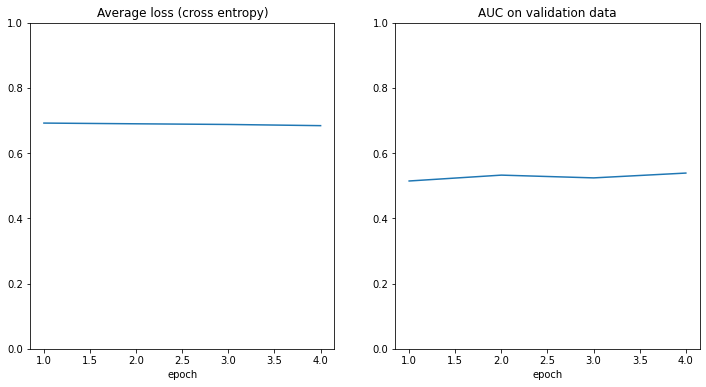

In [527]:
# plotting loss
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Average loss (cross entropy)")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.ylim([0, 1])
plt.xlabel("epoch")
plt.plot(x, y)

# plotting AUC
plt.subplot(1, 2, 2)
plt.title("AUC on validation data")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim([0, 1])
plt.plot(x, y)

plt.show()

In [516]:
model.load_state_dict(torch.load(
    os.path.join("best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [523]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.86      0.65       650
           1       0.48      0.14      0.22       598

    accuracy                           0.52      1248
   macro avg       0.50      0.50      0.43      1248
weighted avg       0.50      0.52      0.44      1248



**Discussion**
- In summary, success for GANSformer.
- Between the precision scores at around .50 and a best AUC of 0.54, we see this classifier performs no better than chance. 
- That is, it is not able to discern between real CT scans and those generated by GANSformer.
- We also see that the loss stays constant at ~0.68 from epoch 1 to 4 indicating no improvement over epochs.